##  Covid Image Classification Using ResNet and Inference
COVID-19 detection models utilizing CT images involve the application of machine learning algorithms to analyze chest X-ray images, aiming to identify patterns and features associated with COVID-19 infections. The provided [dataset](https://www.kaggle.com/datasets/plameneduardo/a-covid-multiclass-dataset-of-ct-scans/) comprises 4173 CT scan images of the lungs (Chest CT Scan) with three different classes, including Covid, Healthy, and Others. Our focus for this assignment is solely on the first two classes.*italicized text*

### Download the Dataset

You can download the dataset of this relevant exercise using the code snippet below. Just note that you need to create an account in Kaggle first and then follow the steps below to receive your `kaggle.json` file and then upload it below:
1. Go to your Kaggle account, Scroll to the API section, and Click Expire API Token to remove previous tokens
2. Click on Create New API Token - It will download the `kaggle.json` file on your machine.

If you need more details to read, you can refer to this [link](https://www.kaggle.com/discussions/general/156610).


In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"javadrazi","key":"ae759ea5b392e87a3d9e6dc678d78f87"}'}

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download plameneduardo/a-covid-multiclass-dataset-of-ct-scans/

a-covid-multiclass-dataset-of-ct-scans.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -qq -u ./a-covid-multiclass-dataset-of-ct-scans.zip

### Preprocessing

* The existing data structure consists of patient-wise subfolders. Thus, the initial step involves copying all images into the Covid, Healthy, and Other folders while eliminating any subfolders.

* Count the data in each class to determine if there is an imbalance issue or not.

In [ ]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import cv2
import numpy as np
from sklearn import utils
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

 Creating ./data with its subfolders, splitting the files, and saving each file to its respective directory.

In [ ]:
!mkdir ./data
!mkdir ./data/train
!mkdir ./data/test
!mkdir ./data/train/covid
!mkdir ./data/train/healthy
!mkdir ./data/test/covid
!mkdir ./data/test/healthy

mkdir: cannot create directory ‘./data’: File exists
mkdir: cannot create directory ‘./data/train’: File exists
mkdir: cannot create directory ‘./data/test’: File exists
mkdir: cannot create directory ‘./data/train/covid’: File exists
mkdir: cannot create directory ‘./data/train/healthy’: File exists
mkdir: cannot create directory ‘./data/test/covid’: File exists
mkdir: cannot create directory ‘./data/test/healthy’: File exists


In [ ]:
def copyfiles(source, dest):
    file_names = []
    for foldername, subfolders, filenames in os.walk(source):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            file_names.append(file_path)

    train_files, test_files = train_test_split(file_names, test_size=0.2, random_state=42)
    for file_path in train_files:
        shutil.copy(file_path, os.path.join('./data/train' + dest, os.path.basename(file_path)))
    for file_path in test_files:
        shutil.copy(file_path, os.path.join('./data/test' + dest, os.path.basename(file_path)))

copyfiles('./New_Data_CoV2/Covid', '/covid')
copyfiles('./New_Data_CoV2/Healthy', '/healthy')

In [ ]:
def count_files(directory_path):
    file_count = 0
    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

print('The total number of files in trainset:',  count_files('./data/train/'))
print('The total number of files in testset:',  count_files('./data/test/'))

The total number of files in trainset: 2046
The total number of files in testset: 548


Visualize the dataset and plot some randomly selected sample images from the data.

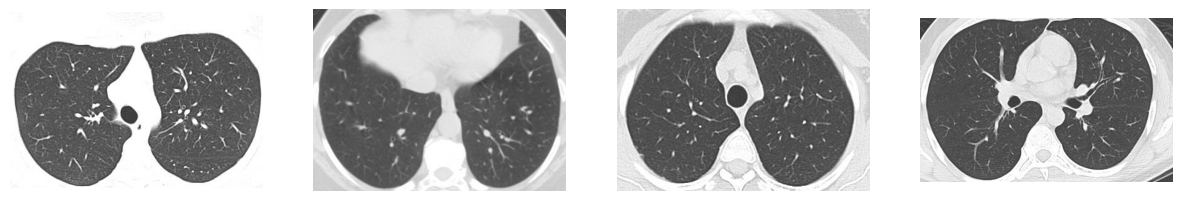

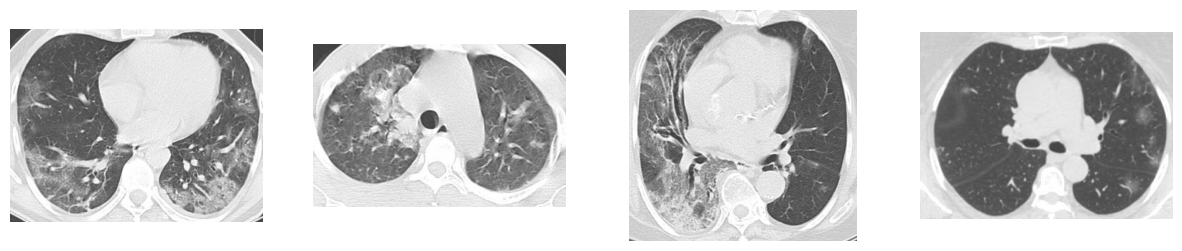

In [ ]:
def plot_images_in_row(folder_path, num_images=4):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = random.sample(image_files, min(num_images, len(image_files)))
    plt.figure(figsize=(15, 3))

    for i, image_file in enumerate(selected_images, start=1):
        plt.subplot(1, num_images, i)
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

covid_folder = './data/train/covid'
healthy_folder = './data/train/healthy'

plot_images_in_row(healthy_folder)
plot_images_in_row(covid_folder)

Create data loaders and apply preprocessing techniques, as well as augmentation and transformation methods, to enhance the model's performance. Also, split the data into train and test sets.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

batch_size = 16

covid_train = os.listdir('./data/train/covid')
healthy_train = os.listdir('./data/train/healthy')

train_dataset = datasets.ImageFolder(root='./data/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='./data/test', transform=transform_test)

class_counts = [covid_train, healthy_train]
total_samples = sum(map(len, class_counts))
class_freq = [len(class_sample) / total_samples for class_sample in class_counts]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### ResNet

* Define your model here. You don't need to code it from scratch, and you can also utilize transfer learning if you believe it would enhance your model's performance.

* If a class imbalance problem exists, recommend a solution and implement it.

In [ ]:
resnet_model = models.resnet18(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)
resnet_model = resnet_model.to(device)

class_weights = torch.FloatTensor([1.0 / freq for freq in class_freq]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def fit_model(epochs, model, criterion, optimizer, Train, Test):

    train_acc, train_loss = [], []
    test_acc, test_loss = [], []

    for epoch in range(epochs):
        epoch_acc, epoch_loss = 0, 0
        model = model.train()

        with tqdm.tqdm(enumerate(Train), total=len(Train)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                optimizer.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.detach().item()
                _, pred = output.data.topk(1, dim=1)
                epoch_acc += (pred.t() == labels).sum().item()

        train_loss.append(epoch_loss/(i+1))
        train_acc.append(epoch_acc/len(Train.dataset))

        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc/len(Train.dataset)))

        epoch_acc, epoch_loss = 0, 0
        model.eval()

        with tqdm.tqdm(enumerate(Test), total=len(Test)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = criterion(output, labels)

                epoch_loss += loss.detach().item()
                _, pred = output.data.topk(1, dim=1)

                epoch_acc += (pred.t() == labels).sum().item()

        test_loss.append(epoch_loss/(i+1))
        test_acc.append(epoch_acc/len(Test.dataset))

        print('Epoch: %d | Loss: %.4f | Test Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc/len(Test.dataset)))

    return train_loss, train_acc, test_loss, test_acc


In [ ]:
epochs = 40
train_loss , train_acc, test_loss, test_acc = fit_model(epochs, resnet_model,
                                                        criterion, optimizer,
                                                        train_loader, test_loader)

100%|██████████| 64/64 [00:15<00:00,  4.14it/s]


Epoch: 0 | Loss: 0.2101 | Train Accuracy: 0.9022


100%|██████████| 18/18 [00:05<00:00,  3.13it/s]

Epoch: 0 | Loss: 0.2012 | Test Accuracy: 0.9048



100%|██████████| 64/64 [00:16<00:00,  3.82it/s]

Epoch: 1 | Loss: 0.0834 | Train Accuracy: 0.9712



100%|██████████| 18/18 [00:04<00:00,  4.20it/s]

Epoch: 1 | Loss: 0.1115 | Test Accuracy: 0.9560



100%|██████████| 64/64 [00:13<00:00,  4.86it/s]

Epoch: 2 | Loss: 0.0496 | Train Accuracy: 0.9800



100%|██████████| 18/18 [00:02<00:00,  6.81it/s]

Epoch: 2 | Loss: 0.0417 | Test Accuracy: 0.9853



100%|██████████| 64/64 [00:12<00:00,  5.19it/s]

Epoch: 3 | Loss: 0.0406 | Train Accuracy: 0.9878



100%|██████████| 18/18 [00:02<00:00,  6.10it/s]

Epoch: 3 | Loss: 0.0672 | Test Accuracy: 0.9689



100%|██████████| 64/64 [00:11<00:00,  5.43it/s]

Epoch: 4 | Loss: 0.0292 | Train Accuracy: 0.9927



100%|██████████| 18/18 [00:03<00:00,  4.67it/s]

Epoch: 4 | Loss: 0.0703 | Test Accuracy: 0.9744



100%|██████████| 64/64 [00:11<00:00,  5.74it/s]

Epoch: 5 | Loss: 0.0251 | Train Accuracy: 0.9902



100%|██████████| 18/18 [00:04<00:00,  4.26it/s]

Epoch: 5 | Loss: 0.0324 | Test Accuracy: 0.9853



100%|██████████| 64/64 [00:11<00:00,  5.81it/s]

Epoch: 6 | Loss: 0.0116 | Train Accuracy: 0.9980



100%|██████████| 18/18 [00:03<00:00,  5.17it/s]

Epoch: 6 | Loss: 0.0446 | Test Accuracy: 0.9762



100%|██████████| 64/64 [00:15<00:00,  4.02it/s]

Epoch: 7 | Loss: 0.0038 | Train Accuracy: 1.0000



100%|██████████| 18/18 [00:04<00:00,  4.41it/s]

Epoch: 7 | Loss: 0.0448 | Test Accuracy: 0.9853



100%|██████████| 64/64 [00:16<00:00,  3.85it/s]

Epoch: 8 | Loss: 0.0016 | Train Accuracy: 1.0000



100%|██████████| 18/18 [00:05<00:00,  3.41it/s]

Epoch: 8 | Loss: 0.0655 | Test Accuracy: 0.9744



100%|██████████| 64/64 [00:12<00:00,  5.13it/s]

Epoch: 9 | Loss: 0.0049 | Train Accuracy: 0.9990



100%|██████████| 18/18 [00:03<00:00,  4.76it/s]

Epoch: 9 | Loss: 0.1055 | Test Accuracy: 0.9725



100%|██████████| 64/64 [00:12<00:00,  5.21it/s]

Epoch: 10 | Loss: 0.0105 | Train Accuracy: 0.9966



100%|██████████| 18/18 [00:02<00:00,  6.97it/s]

Epoch: 10 | Loss: 0.0534 | Test Accuracy: 0.9744



100%|██████████| 64/64 [00:12<00:00,  5.13it/s]

Epoch: 11 | Loss: 0.0170 | Train Accuracy: 0.9941



100%|██████████| 18/18 [00:02<00:00,  6.87it/s]

Epoch: 11 | Loss: 0.1978 | Test Accuracy: 0.9505



100%|██████████| 64/64 [00:12<00:00,  5.21it/s]

Epoch: 12 | Loss: 0.0358 | Train Accuracy: 0.9868



100%|██████████| 18/18 [00:02<00:00,  6.67it/s]

Epoch: 12 | Loss: 0.0551 | Test Accuracy: 0.9762



100%|██████████| 64/64 [00:12<00:00,  5.07it/s]

Epoch: 13 | Loss: 0.0105 | Train Accuracy: 0.9966



100%|██████████| 18/18 [00:02<00:00,  6.08it/s]

Epoch: 13 | Loss: 0.0379 | Test Accuracy: 0.9853



100%|██████████| 64/64 [00:12<00:00,  5.07it/s]

Epoch: 14 | Loss: 0.0122 | Train Accuracy: 0.9956



100%|██████████| 18/18 [00:02<00:00,  6.59it/s]

Epoch: 14 | Loss: 0.0260 | Test Accuracy: 0.9872



100%|██████████| 64/64 [00:12<00:00,  5.09it/s]

Epoch: 15 | Loss: 0.0334 | Train Accuracy: 0.9902



100%|██████████| 18/18 [00:02<00:00,  6.90it/s]

Epoch: 15 | Loss: 0.0715 | Test Accuracy: 0.9689



100%|██████████| 64/64 [00:12<00:00,  5.16it/s]

Epoch: 16 | Loss: 0.0115 | Train Accuracy: 0.9956



100%|██████████| 18/18 [00:03<00:00,  5.79it/s]

Epoch: 16 | Loss: 0.0293 | Test Accuracy: 0.9853



100%|██████████| 64/64 [00:11<00:00,  5.51it/s]

Epoch: 17 | Loss: 0.0039 | Train Accuracy: 0.9990



100%|██████████| 18/18 [00:03<00:00,  4.84it/s]

Epoch: 17 | Loss: 0.0258 | Test Accuracy: 0.9890



100%|██████████| 64/64 [00:11<00:00,  5.74it/s]

Epoch: 18 | Loss: 0.0021 | Train Accuracy: 0.9995



100%|██████████| 18/18 [00:04<00:00,  4.08it/s]

Epoch: 18 | Loss: 0.0258 | Test Accuracy: 0.9890



100%|██████████| 64/64 [00:10<00:00,  5.84it/s]


Epoch: 19 | Loss: 0.0014 | Train Accuracy: 1.0000


100%|██████████| 18/18 [00:03<00:00,  4.98it/s]

Epoch: 19 | Loss: 0.0295 | Test Accuracy: 0.9890



100%|██████████| 64/64 [00:11<00:00,  5.48it/s]

Epoch: 20 | Loss: 0.0014 | Train Accuracy: 1.0000



100%|██████████| 18/18 [00:03<00:00,  5.68it/s]

Epoch: 20 | Loss: 0.0236 | Test Accuracy: 0.9908



100%|██████████| 64/64 [00:12<00:00,  5.29it/s]

Epoch: 21 | Loss: 0.0004 | Train Accuracy: 1.0000



100%|██████████| 18/18 [00:02<00:00,  6.76it/s]

Epoch: 21 | Loss: 0.0221 | Test Accuracy: 0.9890



100%|██████████| 64/64 [00:13<00:00,  4.84it/s]

Epoch: 22 | Loss: 0.0005 | Train Accuracy: 1.0000



100%|██████████| 18/18 [00:03<00:00,  5.43it/s]

Epoch: 22 | Loss: 0.0383 | Test Accuracy: 0.9872



100%|██████████| 64/64 [00:12<00:00,  5.21it/s]

Epoch: 23 | Loss: 0.0005 | Train Accuracy: 1.0000



100%|██████████| 18/18 [00:02<00:00,  6.85it/s]

Epoch: 23 | Loss: 0.0323 | Test Accuracy: 0.9872



100%|██████████| 64/64 [00:12<00:00,  5.17it/s]

Epoch: 24 | Loss: 0.0030 | Train Accuracy: 0.9990



100%|██████████| 18/18 [00:02<00:00,  6.70it/s]

Epoch: 24 | Loss: 0.0634 | Test Accuracy: 0.9762



100%|██████████| 64/64 [00:12<00:00,  5.23it/s]

Epoch: 25 | Loss: 0.0064 | Train Accuracy: 0.9971



100%|██████████| 18/18 [00:02<00:00,  6.84it/s]

Epoch: 25 | Loss: 0.0348 | Test Accuracy: 0.9835



100%|██████████| 64/64 [00:12<00:00,  5.17it/s]

Epoch: 26 | Loss: 0.0240 | Train Accuracy: 0.9917



100%|██████████| 18/18 [00:02<00:00,  6.53it/s]

Epoch: 26 | Loss: 0.0496 | Test Accuracy: 0.9799



100%|██████████| 64/64 [00:12<00:00,  5.17it/s]

Epoch: 27 | Loss: 0.0036 | Train Accuracy: 1.0000



100%|██████████| 18/18 [00:02<00:00,  6.98it/s]

Epoch: 27 | Loss: 0.0900 | Test Accuracy: 0.9835



100%|██████████| 64/64 [00:12<00:00,  5.22it/s]

Epoch: 28 | Loss: 0.0172 | Train Accuracy: 0.9922



100%|██████████| 18/18 [00:02<00:00,  6.70it/s]

Epoch: 28 | Loss: 0.0909 | Test Accuracy: 0.9634



100%|██████████| 64/64 [00:12<00:00,  5.19it/s]

Epoch: 29 | Loss: 0.0256 | Train Accuracy: 0.9892



100%|██████████| 18/18 [00:02<00:00,  6.23it/s]

Epoch: 29 | Loss: 0.3773 | Test Accuracy: 0.9231



100%|██████████| 64/64 [00:11<00:00,  5.42it/s]

Epoch: 30 | Loss: 0.0109 | Train Accuracy: 0.9966



100%|██████████| 18/18 [00:04<00:00,  4.39it/s]

Epoch: 30 | Loss: 0.0683 | Test Accuracy: 0.9817



100%|██████████| 64/64 [00:10<00:00,  5.82it/s]

Epoch: 31 | Loss: 0.0026 | Train Accuracy: 1.0000



100%|██████████| 18/18 [00:03<00:00,  4.76it/s]

Epoch: 31 | Loss: 0.0403 | Test Accuracy: 0.9835



100%|██████████| 64/64 [00:11<00:00,  5.52it/s]

Epoch: 32 | Loss: 0.0015 | Train Accuracy: 1.0000



100%|██████████| 18/18 [00:03<00:00,  5.63it/s]

Epoch: 32 | Loss: 0.0463 | Test Accuracy: 0.9853



100%|██████████| 64/64 [00:12<00:00,  5.30it/s]


Epoch: 33 | Loss: 0.0007 | Train Accuracy: 1.0000


100%|██████████| 18/18 [00:02<00:00,  6.82it/s]

Epoch: 33 | Loss: 0.0393 | Test Accuracy: 0.9872



100%|██████████| 64/64 [00:12<00:00,  5.13it/s]

Epoch: 34 | Loss: 0.0010 | Train Accuracy: 0.9995



100%|██████████| 18/18 [00:02<00:00,  6.87it/s]

Epoch: 34 | Loss: 0.0429 | Test Accuracy: 0.9853



100%|██████████| 64/64 [00:13<00:00,  4.59it/s]

Epoch: 35 | Loss: 0.0096 | Train Accuracy: 0.9961



100%|██████████| 18/18 [00:02<00:00,  6.97it/s]

Epoch: 35 | Loss: 0.0468 | Test Accuracy: 0.9872



100%|██████████| 64/64 [00:12<00:00,  5.08it/s]

Epoch: 36 | Loss: 0.0019 | Train Accuracy: 0.9995



100%|██████████| 18/18 [00:02<00:00,  6.92it/s]

Epoch: 36 | Loss: 0.0186 | Test Accuracy: 0.9927



100%|██████████| 64/64 [00:12<00:00,  5.12it/s]

Epoch: 37 | Loss: 0.0021 | Train Accuracy: 0.9990



100%|██████████| 18/18 [00:02<00:00,  6.78it/s]

Epoch: 37 | Loss: 0.0489 | Test Accuracy: 0.9853



100%|██████████| 64/64 [00:12<00:00,  5.12it/s]

Epoch: 38 | Loss: 0.0011 | Train Accuracy: 0.9995



100%|██████████| 18/18 [00:02<00:00,  6.85it/s]

Epoch: 38 | Loss: 0.0450 | Test Accuracy: 0.9872



100%|██████████| 64/64 [00:12<00:00,  5.16it/s]

Epoch: 39 | Loss: 0.0191 | Train Accuracy: 0.9927



100%|██████████| 18/18 [00:02<00:00,  6.86it/s]

Epoch: 39 | Loss: 0.2023 | Test Accuracy: 0.9524


Plot Accuracy and Loss plots for both training and validation parts.

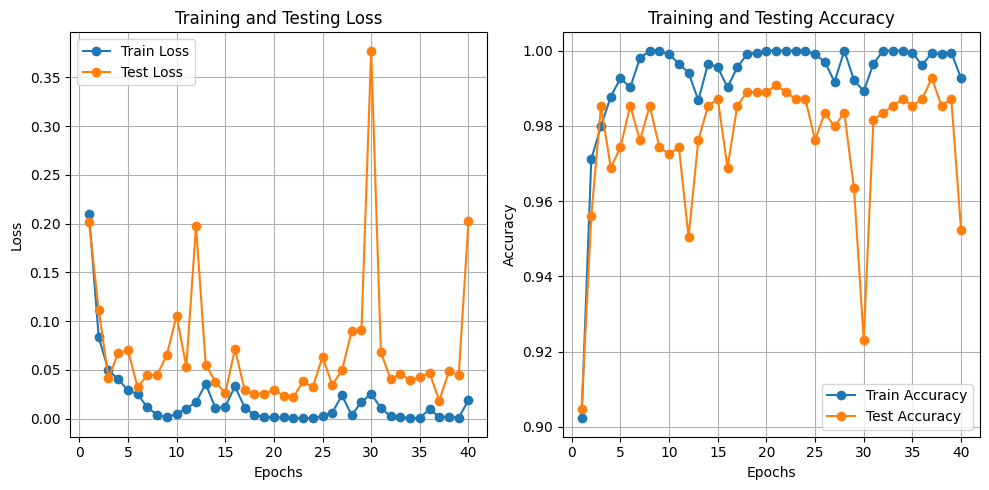

In [ ]:
epochs = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='o')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, test_acc, label='Test Accuracy', marker='o')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Interpretability
Here, we aim to select an interpretability algorithm that aids in comprehending the model's decision-making process, debugging, and explaining predictions to non-technical stakeholders. Let's opt for the [Grad-CAM](https://arxiv.org/abs/1610.02391) technique. Grad-CAM, short for Gradient-weighted Class Activation Mapping, highlights important regions in an image that contribute to the model's prediction. This is achieved by computing the gradients of the target class with respect to the final convolutional layer. First, explain about this method and how it works, then implement this technique and visualize the resulting heatmaps.

[GradCam github](https://github.com/jacobgil/pytorch-grad-cam)

**Your Answer (10 points)**:


GradCAM leverages the gradient information flowing into the last convolutional layer of a CNN to produce a visual explanation for the model's predictions. This method highlights the discriminative regions used by the network to identify a particular class in the image.

To provide an intuition on how it works, consider a CNN classifier. it activates different patterns or features it has learned over the course of training. GradCAM provides insight into which of these activations in the convolutional layers were most influential for a given class decision. It backtracks from the output layer to the target convolutional layer, using the gradients of the target class with respect to the feature maps. This gradient information signifies the importance of each neuron for the classification decision. By averaging these gradients, we can weight the feature maps to produce a heatmap that signifies the importance of spatial regions in the original image for the predicted class.

During the forward pass, the network computes the activations at each layer. Once the output is obtained, the backward pass computes the gradient of the output class score with respect to the feature maps of a convolutional layer. These gradients are global-average-pooled to obtain a set of weights, each indicating the importance of the corresponding feature map.

The GradCAM heatmap is then generated by performing a weighted combination of the feature maps, followed by a ReLU activation. The positive values in this heatmap indicate the pixels that have a positive influence on the class of interest. The heatmap is then upsampled to the size of the input image to visualize the important regions.

This method is particularly useful as it requires no modification to the existing architecture and can be applied to any CNN-based model, providing a powerful and flexible tool for AI interpretability.

**GradCam usage (60 points)**:

In [ ]:
'''
  Initially, it is crucial to ensure that the model is in Evaluation mode.
  Failing to do so during result verification could inadvertently alter the
  model's weights, leading to inaccurate and unreliable results.
'''
resnet_model.eval()
device = "cpu"
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Within this section, leverage GradCam to create a function that generates a plot for a given image address. The function should display the image and overlay a heatmap (which was generated by GradCam) on it in a separate plot. **For this, use the 4th layer of your trained Resent**.

In [29]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_GradCam(image_path, model, target_layer):
    # Preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0)

    # Set model to evaluation mode
    model.eval()

    # Forward pass for the image
    features = []
    def hook_function(module, input, output):
        output.retain_grad()  # Retain gradients for the output
        features.append(output)
    handle = target_layer.register_forward_hook(hook_function)

    output = model(image_tensor)
    handle.remove()

    # Use the output to compute gradients
    class_idx = torch.argmax(output, dim=1).item()
    score = output[:, class_idx]
    model.zero_grad()
    score.backward()

    # GradCAM computation
    gradients = features[0].grad  # Now gradients should be retained
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    activations = features[0].squeeze(0)
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=0).detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to the size of the original image
    heatmap = cv2.resize(heatmap, (image.width, image.height))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on original image
    superimposed_img = heatmap * 0.4 + np.array(image)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    # Visualize the original image and the heatmap
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('GradCAM Heatmap')
    plt.axis('off')

    plt.show()


Visualize GradCAM heatmaps for 10 images and interpret your model's performance and identify areas your model is paying attention to based on the GradCAM output. For this, use the function you wrote in the previous section.

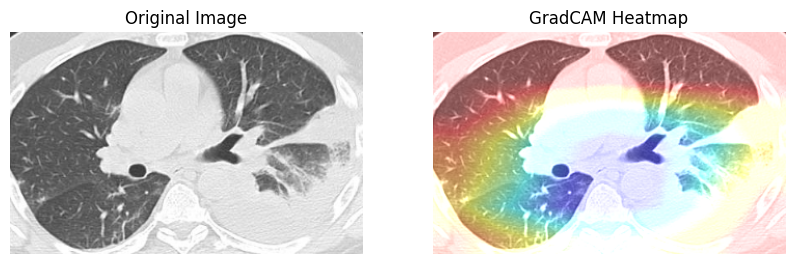

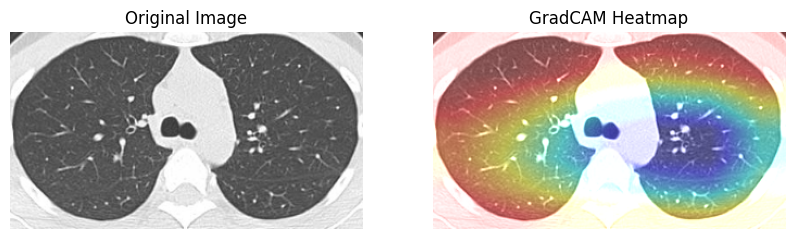

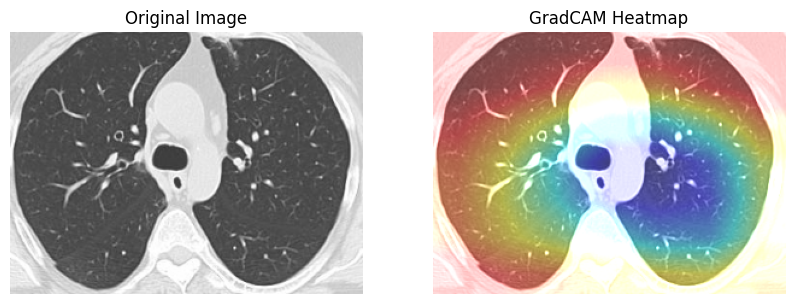

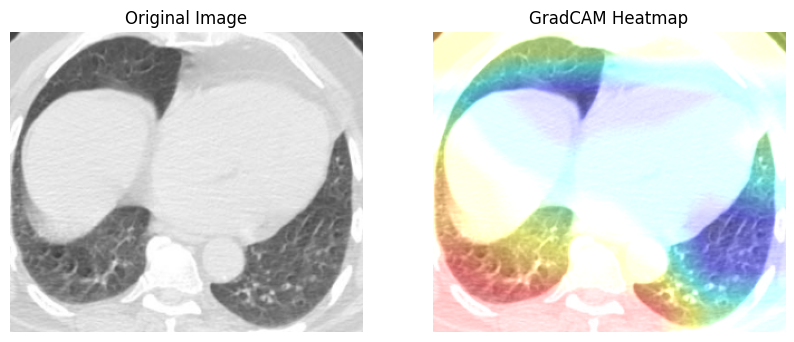

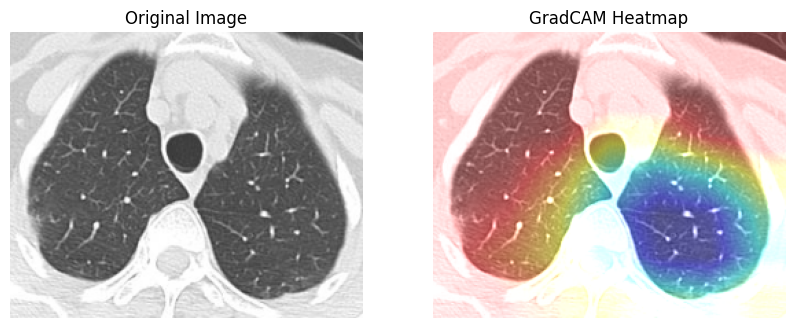

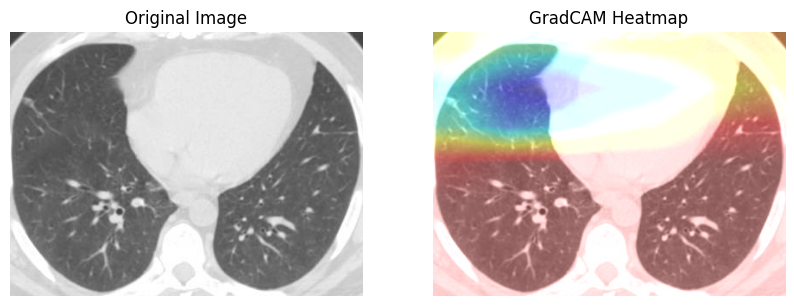

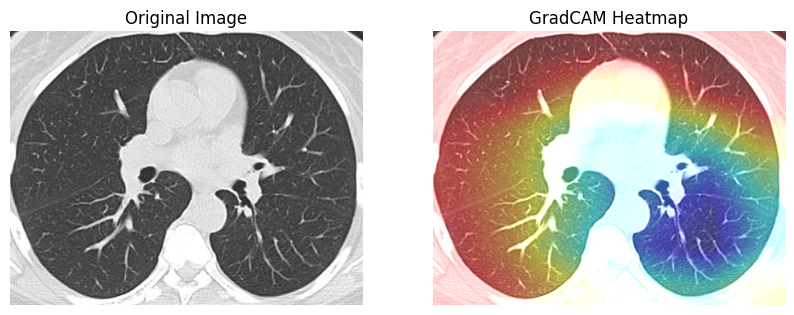

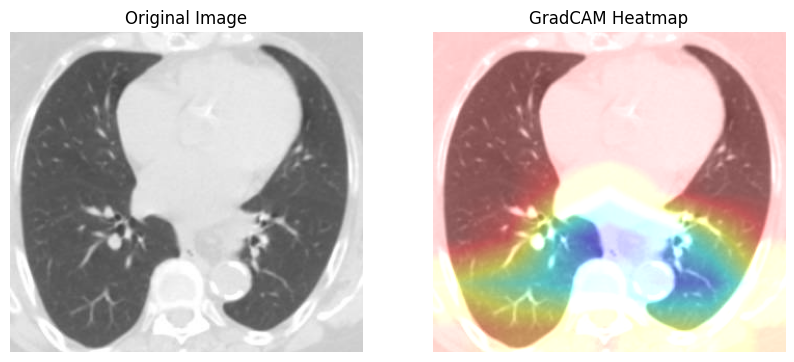

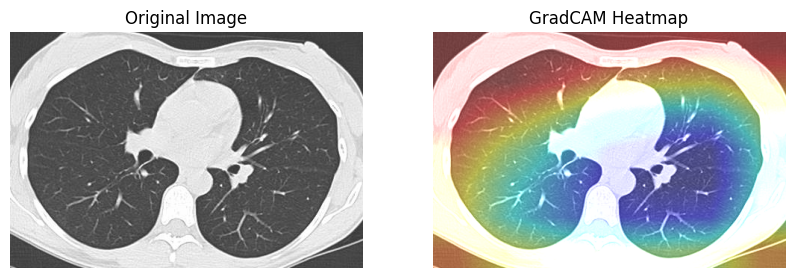

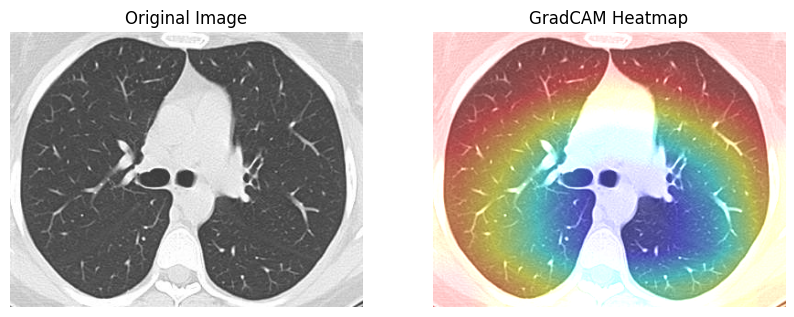

In [ ]:
import os
import random

def select_images_from_folder(folder_path, num_images=5):
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return random.sample(image_files, min(len(image_files), num_images))

covid_folder = './data/test/covid'
healthy_folder = './data/test/healthy'

# Select images
covid_images = select_images_from_folder(covid_folder, 5)
healthy_images = select_images_from_folder(healthy_folder, 5)

# Visualize GradCAM heatmaps
for image_path in covid_images + healthy_images:
    plot_GradCam(image_path, resnet_model, resnet_model.layer4)


Now, envision that we have trained a neural network, obtained heatmaps, and achieved a model performance of 95%. Despite utilizing Grad-CAM, the heatmaps reveal a consistent focus on the corners, evident across numerous images. In your perspective, what could be the underlying problem, and how might we address and overcome this issue?

**Your Answer (10 points)**:

The presence of corner-focused heatmaps, despite a high F1 score, hints at potential issues with the neural network's training process. This phenomenon, often termed "corner artifact," implies that the model may be leveraging irrelevant features for its predictions.

The root cause could stem from several factors:

1. **Data Quality**: Systematic artifacts in the training data that are consistently located at the corners of the images. Such artifacts can arise during image acquisition or preprocessing and can mislead the model.

2. **Overfitting**: The model's high performance on the training data might not generalize well to unseen data if it has learned to associate these corner artifacts with the target class.

3. **Insufficient Data Augmentation**: If the training data lacks variety, especially in terms of transformations like rotation and translation, the model might not learn to focus on the relevant regions within the image.

4. **Model Architecture and Receptive Field**: The model's architecture, particularly the size and stride of filters in the convolutional layers, may be predisposed to focusing on edges and corners.

To overcome this issue, a multifaceted approach is warranted:

1. **Data Inspection and Cleanup**: Thoroughly review the dataset for any recurring artifacts. Preprocessing steps such as cropping or masking can help remove such noise.

2. **Robust Data Augmentation**: Introduce more aggressive augmentation techniques that alter the image's edges and corners, thereby encouraging the model to focus on central regions.

3. **Regularization**: Incorporate regularization techniques like dropout or spatial dropout during training to discourage the model from depending on features from the image periphery.

4. **Architectural Adjustments**: Modify the model's architecture to ensure that the receptive fields of the convolutional layers are more aligned with the central areas of interest.

5. **Attention Mechanisms**: Implement attention-based models or layers that can explicitly learn to focus on relevant parts of the image.

Addressing these factors should help redirect the model's focus away from the corners and towards diagnostically meaningful features, ultimately enhancing the model's interpretability and clinical utility.